In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

In [2]:
def gaussian_blur_difference(image):
    """Apply Gaussian blur and compute absolute difference."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    diff = cv2.absdiff(gray, blurred)
    return cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)

def error_level_analysis(image, quality=95):
    """Perform Error Level Analysis (ELA) on an image."""
    try:
        im = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        temp_compressed = "temp_compressed.jpg"
        im.save(temp_compressed, "JPEG", quality=quality)
        compressed = Image.open(temp_compressed)
        ela_image = ImageChops.difference(im, compressed)
        ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
        os.remove(temp_compressed)
        return cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"ELA Error: {e}")
        return None

def preprocess_image(image, image_size=(128, 128)):
    """Apply Gaussian Blur Difference and Error Level Analysis."""
    gb_diff = gaussian_blur_difference(image)
    ela_image = error_level_analysis(image)
    if ela_image is None:
        return None
    gb_resized = cv2.resize(gb_diff, image_size)
    ela_resized = cv2.resize(ela_image, image_size)
    return cv2.addWeighted(gb_resized, 0.2, ela_resized, 0.8, 0)

In [3]:
def prepare_dataset(dataset_path, image_size=(128, 128), data_limit=None):
    """Load and preprocess images, returning feature matrix X and labels y."""
    X, y = [], []
    for class_name in ["Au", "Tp"]:
        class_path = os.path.join(dataset_path, class_name)
        label = 0 if class_name == "Au" else 1
        data_list = (
            os.listdir(class_path)[0:data_limit]
            if data_limit
            else os.listdir(class_path)
        )
        for img_file in data_list:
            if img_file.lower().endswith(
                (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
            ):
                img = cv2.imread(os.path.join(class_path, img_file))
                processed_img = preprocess_image(img, image_size)
                if processed_img is not None:
                    X.append(processed_img)
                    y.append(label)
    return np.array(X), np.array(y)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply,
    Conv2D, Concatenate, Activation, Lambda, Add
)

# Define CBAM Block
def cbam_block(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    # Channel Attention
    shared_layer_one = Dense(channel // reduction_ratio, activation='relu')
    shared_layer_two = Dense(channel)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_out = shared_layer_two(shared_layer_one(avg_pool))

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_out = shared_layer_two(shared_layer_one(max_pool))

    channel_attention = Activation('sigmoid')(Add()([avg_out, max_out]))
    channel_refined = Multiply()([input_feature, channel_attention])

    # Spatial Attention
    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])

    spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    refined_feature = Multiply()([channel_refined, spatial_attention])

    return refined_feature

# Build model with CBAM
def build_model_with_cbam(input_shape=(128, 128, 3), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (5, 5), strides=1, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, (5, 5), strides=1, padding='same', activation='relu')(x)

    # ✅ Insert CBAM after second Conv2D
    x = cbam_block(x)
    
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [6]:
from tensorflow.keras.utils import to_categorical
def train_model(model, X, y, epochs=12):
    """Train the model with optimized parameters and class weighting."""

    # One-hot encode the labels
    y = to_categorical(y, num_classes=2)

    # Train/val/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42
    )
    print(X_train.shape, y_train.shape)

    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test.argmax(axis=1), random_state=42
    )
    print(X_test.shape, y_test.shape)
    print(X_val.shape, y_val.shape)

    # Normalize pixel values
    X_train = X_train.astype("float32") / 255.0
    X_val = X_val.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
    )
    return model, history, X_test, y_test

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
import numpy as np

def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and generate plots."""
    
    # Step 1: Evaluate and unpack loss and accuracy
    results = model.evaluate(X_test, y_test, verbose=1)
    test_loss = results[0]
    test_accuracy = results[1] if len(results) > 1 else None
    
    print("\n📊 Evaluation Results:")
    print(f"Loss:     {test_loss:.4f}")
    if test_accuracy is not None:
        print(f"Accuracy: {test_accuracy:.4f}")
    
    # Step 2: Predict
    y_pred_proba = model.predict(X_test)
    if y_pred_proba.shape[1] == 1:
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_test_labels = y_test.flatten()
        y_pred_scores = y_pred_proba.flatten()
    else:
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)
        y_pred_scores = y_pred_proba[:, 1] if y_pred_proba.shape[1] > 1 else y_pred_proba[:, 0]

    # Step 3: Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred))

    # Step 4: Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Forged", "Forged"],
        yticklabels=["Non-Forged", "Forged"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Step 5: ROC Curve
    fpr, tpr, _ = roc_curve(y_test_labels, y_pred_scores)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Step 6: Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_labels, y_pred_scores)
    plt.figure()
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()


In [8]:
# Step 1: Build model
image_size = (128, 128)
model = build_model_with_cbam()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,432 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     25,632 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d_1[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        132 │ reshape[0][0],    │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 32)  │        160 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 32)  │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1, 32)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128,  │          0 │ conv2d_1[0][0],   │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ multiply[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ multiply[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ lambda[0][0],     │
│ (Concatenate)       │ 2)                │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │         99 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 128,  │          0 │ multiply[0][0],   │
│ (Multiply)          │ 32)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,806,057 (64.11 MB)

 Trainable params: 16,806,057 (64.11 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Step 2: Define dataset path and image size
dataset_path = r"../CASIA22"

# Step 3: Prepare dataset
X, y = prepare_dataset(dataset_path, image_size)

In [11]:
# Step 4: Train model
model, history, X_test, y_test = train_model(model, X, y, epochs=12)


(10091, 128, 128, 3) (10091, 2)
(1261, 128, 128, 3) (1261, 2)
(1262, 128, 128, 3) (1262, 2)
Epoch 1/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.6804 - loss: 0.6035 - val_accuracy: 0.6609 - val_loss: 0.6271
Epoch 2/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.7967 - loss: 0.4616 - val_accuracy: 0.8098 - val_loss: 0.4329
Epoch 3/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.8349 - loss: 0.3912 - val_accuracy: 0.8273 - val_loss: 0.4331
Epoch 4/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.8664 - loss: 0.3127 - val_accuracy: 0.8788 - val_loss: 0.3239
Epoch 5/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.8963 - loss: 0.2410 - val_accuracy: 0.8875 - val_loss: 0.2581
Epoch 6/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - accuracy: 0.9187 - loss: 0.1821 - val_accuracy: 0.8970 - val_loss: 0.2356
Epoch 7/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.9323 - loss: 0.1515 - val_accuracy: 0.9089 - val_loss: 0.2318
Epoch

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - accuracy: 0.8906 - loss: 0.3704

📊 Evaluation Results:
Loss:     0.3630
Accuracy: 0.8882
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 302ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       749
           1       0.83      0.91      0.87       512

    accuracy                           0.89      1261
   macro avg       0.88      0.89      0.89      1261
weighted avg       0.89      0.89      0.89      1261



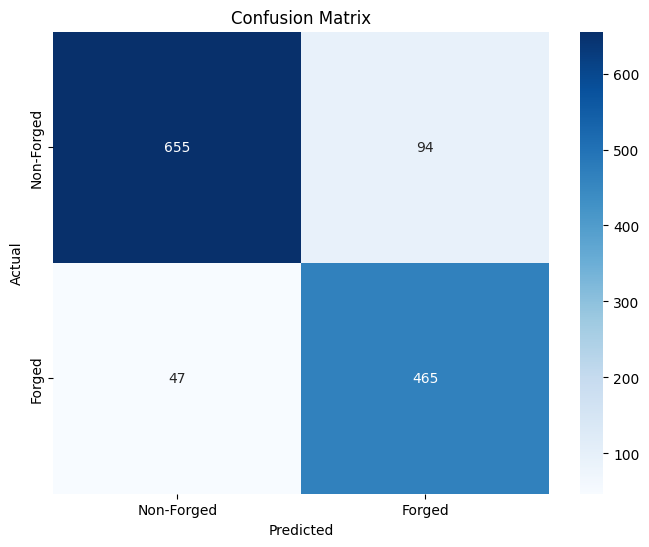

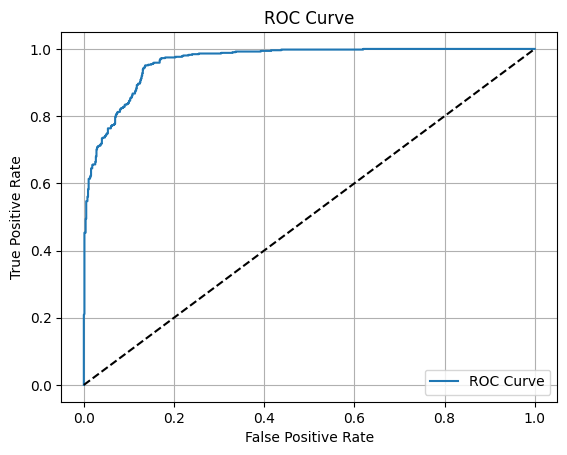

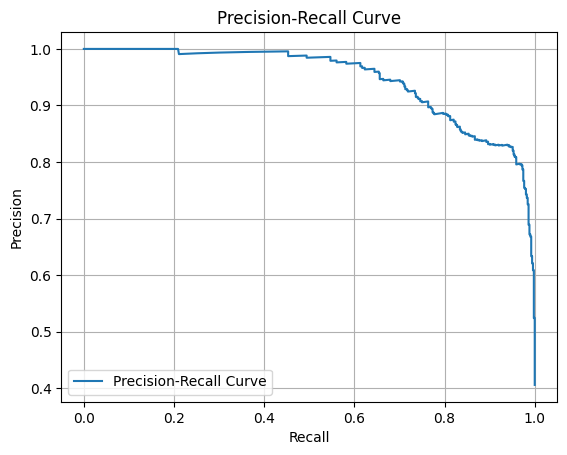

In [12]:
evaluate_model(model, X_test, y_test)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


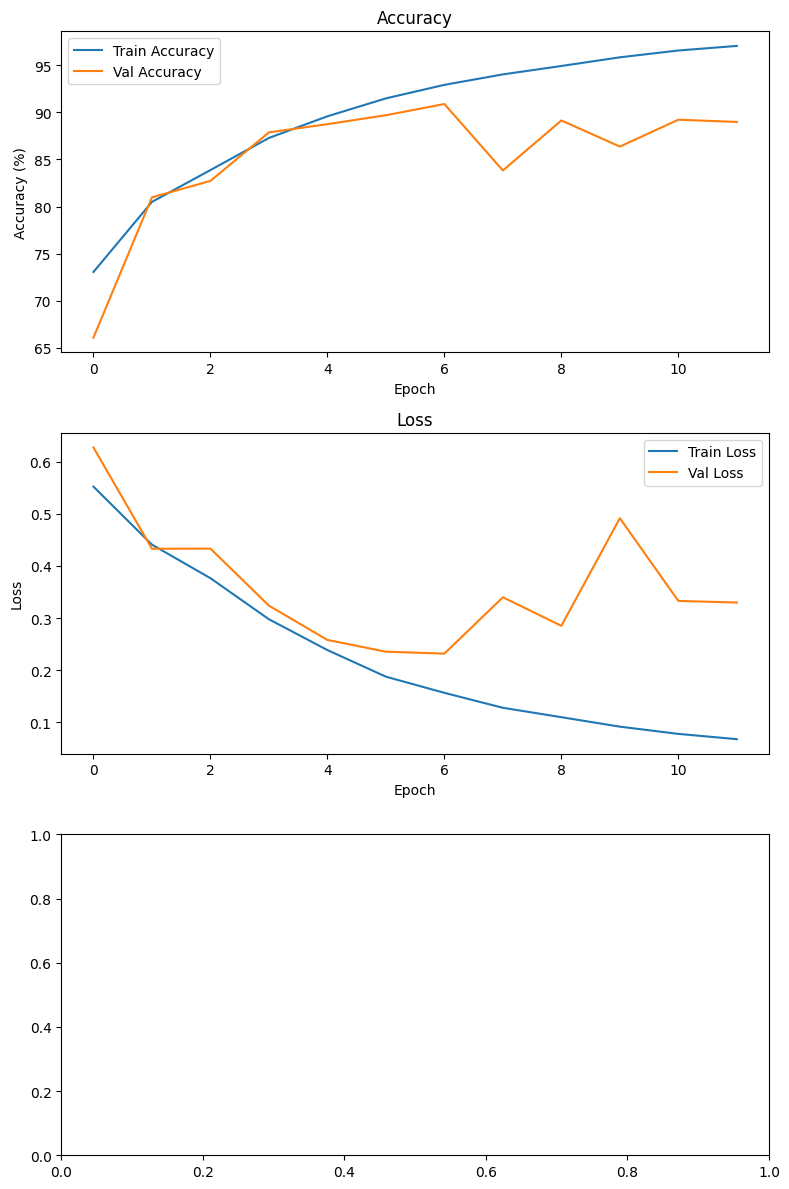

In [13]:
def plot_training_curves(history):
    """Plot training history including loss, accuracy, and AUC on a 0-100% scale."""
    print(history.history.keys())

    fig, ax = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column, taller figure

    # Accuracy (Scaled to 0-100%)
    ax[0].plot(np.array(history.history['accuracy']) * 100, label='Train Accuracy')
    ax[0].plot(np.array(history.history['val_accuracy']) * 100, label='Val Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].set_xlabel('Epoch')
    # ax[0].set_ylim(70, 110)
    ax[0].legend()

    # Loss (Keep original scale)
    ax[1].plot(np.array(history.history['loss']), label='Train Loss')
    ax[1].plot(np.array(history.history['val_loss']), label='Val Loss')
    ax[1].set_title('Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    # ax[1].set_ylim(0, 30)
    ax[1].legend()

    # AUC (Scaled to 0-100%)
    # ax[2].plot(np.array(history.history['auc']) * 100, label='Train AUC')
    # ax[2].plot(np.array(history.history['val_auc']) * 100, label='Val AUC')
    # ax[2].set_title('AUC Score')
    # ax[2].set_ylabel('AUC (%)')
    # ax[2].set_xlabel('Epoch')
    # # ax[2].set_ylim(80, 110)
    # ax[2].legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()
# Step 6: Plot training curves
plot_training_curves(history)